## Monte Carlo Method For Option Pricing


The term 'Monte Carlo Methods' refer to a very broad class of computational based algorithms which in short, are performing repeated random sampling often hundreds of thousands of times to obtain numerical approximations to deterministic problems.

## Geometric Brownian Motion

Before beginning, we first note that we will suppose the underlying follows GBM, meaning the we should obtain the same price given by the Black Scholes Model. The derivation for the solution to the SDE can be found in the Theory repository

## Steps

1.Generate large number of random price paths according to GBM
2.Calculate exercise value of the option for each path
3.Average all the payoffs and discount to present, which is the value of the option



## Generic Code (Very Slow)

In [12]:
## Import Packages
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [29]:
## Initialise parameters
S0 = 100      # current stock price
K = 100       # strike price
T = 1         # time to maturity, years
r = 0.01      # risk-free rate
vol = 0.2     # volatility (%)
N = 100       # number of time steps


In [14]:
## Below is a simple call option calculator. It is not needed, but it is
# helpful to have one built in

norm = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))
    return S * norm(d1) - K * np.exp(-r*T)* norm(d2)

BSMprice = BS_CALL(S0, K, T, r, vol)
BSMprice

8.433318690109608

In [4]:
# Main Monte Carlo Method

def MCarlo(sim, T, N, r, vol, K, S0):
    dt = T/N
    nudt = (r - (1/2)*vol**2)*dt
    lnS0 = np.log(S0)
    
    sum_payoff = 0

    
    start = time.time() #Record start time
    
    for i in range(sim): #How many Simulations
       
        lnSt = lnS0 # Reset first St to current stock price at start of each simulation
        
        for j in range(N):#Time steps
            lnSt = lnSt + nudt + vol*np.sqrt(dt)*np.random.normal() #GMB SDE Solution
            
        ST = np.exp(lnSt)
        payoff = max(0, ST - K)
        sum_payoff = sum_payoff + payoff
      
        
    Call_price = np.exp(-r*T)*sum_payoff/sim #Expected Payoff
  
    
    
    stop = time.time() #End computation time
    duration = stop-start #Time to complete computation with number of sim
    
    return Call_price, duration

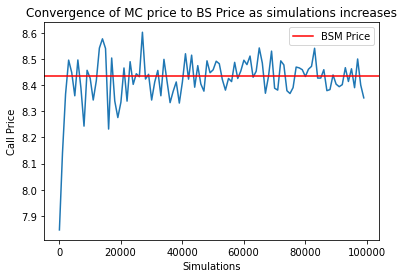

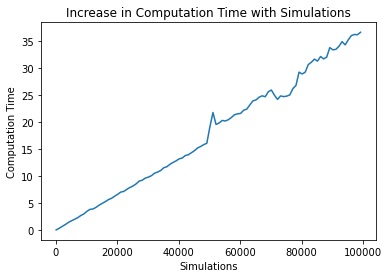

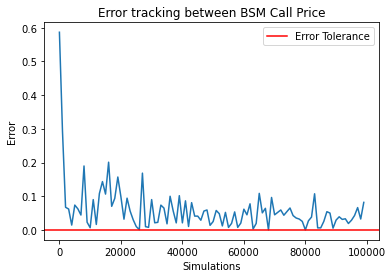

In [7]:
# For recording Monte Carlo simulations with different number of sim
MSPriceArray = []
MSTimeArray = []
ErrorArray = []

maxSim = 100000
minSim = 100
stepSim = 1000

for sim in range(minSim, maxSim, stepSim):
    price, CompTime = MCarlo(sim, T, N, r, vol, K, S0)
    
    MSPriceArray.append(price)
    MSTimeArray.append(CompTime)
    ErrorArray.append(abs(BSMprice-price))

plt.plot(range(minSim, maxSim, stepSim), MSPriceArray)
plt.title('Convergence of MC price to BS Price as simulations increases')
plt.axhline(y=8.43331, color='r', linestyle='-', label='BSM Price')
plt.legend(loc='upper right')
plt.xlabel("Simulations")
plt.ylabel("Call Price")
plt.show()


plt.plot(range(minSim, maxSim, stepSim), MSTimeArray)
plt.title('Increase in Computation Time with Simulations')
plt.xlabel("Simulations")
plt.ylabel("Computation Time")
plt.show()

plt.plot(range(minSim, maxSim, stepSim), ErrorArray)
plt.title('Error tracking between BSM Call Price')
plt.axhline(y=0.001, color='r', linestyle='-', label='Error Tolerance')
plt.legend(loc='upper right')
plt.xlabel("Simulations")
plt.ylabel("Error")
plt.show()   
    

*Observations

1. The call price given by the Monte Carlo Method converges to the price given by the BSM model
2. However, increasing the accuracy is not without cost. The cost to computational time is staggering if we want have enough samples to ensure a good approximation
3. The rate of convergence is very slow. As indicated by the error tracking, even with 100,000 simulations, we could not achieve an error below 0.001

## Vectorised Version (Fast)

In [15]:
def MCarloVect(sim, T, N, r, vol, K, S0):
    dt = T/N
    nudt = (r - (1/2)*vol**2)*dt
    lnS0 = np.log(S0)

    
    ST = np.log(S0) + np.cumsum(nudt + vol*np.sqrt(dt)*np.random.normal(size=(N,sim)),axis=0)
    
    return np.exp(ST)
    

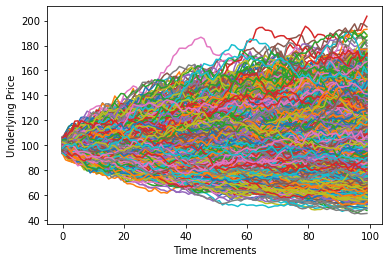

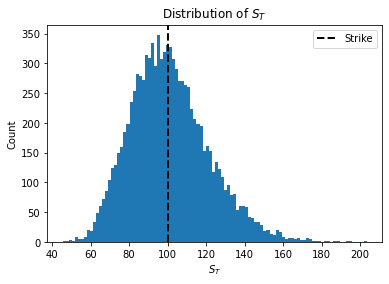

In [24]:
sim = 10000
N = 100
paths = MCarloVect(sim, T, N, r, vol, K, S0)
    
plt.plot(paths)
plt.xlabel("Time Increments")
plt.ylabel("Underlying Price")   
plt.show()

n, bins, patches = plt.hist(paths[-1],bins=100);
plt.axvline(K, color='black', linestyle='dashed', linewidth=2,label="Strike")
plt.title("Distribution of $S_{T}$")
plt.xlabel("$S_{T}$")
plt.ylabel('Count')
plt.legend()
plt.show()
